# Plots for experiments

In [1]:
%load_ext autoreload
%autoreload 2

import os
os.chdir("../")
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn

%matplotlib inline
seaborn.set(font_scale=2)
seaborn.set_style("white")
np.random.seed(1)
np.set_printoptions(precision=6, suppress=True)
plot_height, legend_size, marker_size, line_width = 10, 18, 0.4, 1.2


Model name: 2019-05-25 13:26:04 dataset=mnist_2_6 weak_learner=tree model=plain n_train=-1 n_trials_coord=100 eps=0.300 max_depth=4 lr=1.0
iter: 27  [test] err 1.16% adv_err_lb 98.14% adv_err 100.00%  adv_err_ub 100.00%  |  [valid] err 0.38% adv_err 100.00%  |  [train] err: 0.00%  adv_err: 0.00%  loss: 0.00000  (29.83 min)
Model name: 2019-05-25 13:26:04 dataset=mnist_2_6 weak_learner=tree model=robust_bound n_train=-1 n_trials_coord=100 eps=0.300 max_depth=4 lr=1.0
iter: 47  [test] err 0.70% adv_err_lb 3.47% adv_err 4.97%  adv_err_ub 4.97%  |  [valid] err 0.55% adv_err 5.26%  |  [train] err: 0.09%  adv_err: 1.53%  loss: 0.06522  (90.80 min)


Latex table:
mnist 2 6 & 0.300 &1.2 & 98.1 & 100.0 &   0.7 & 3.5 & 5.0 \\



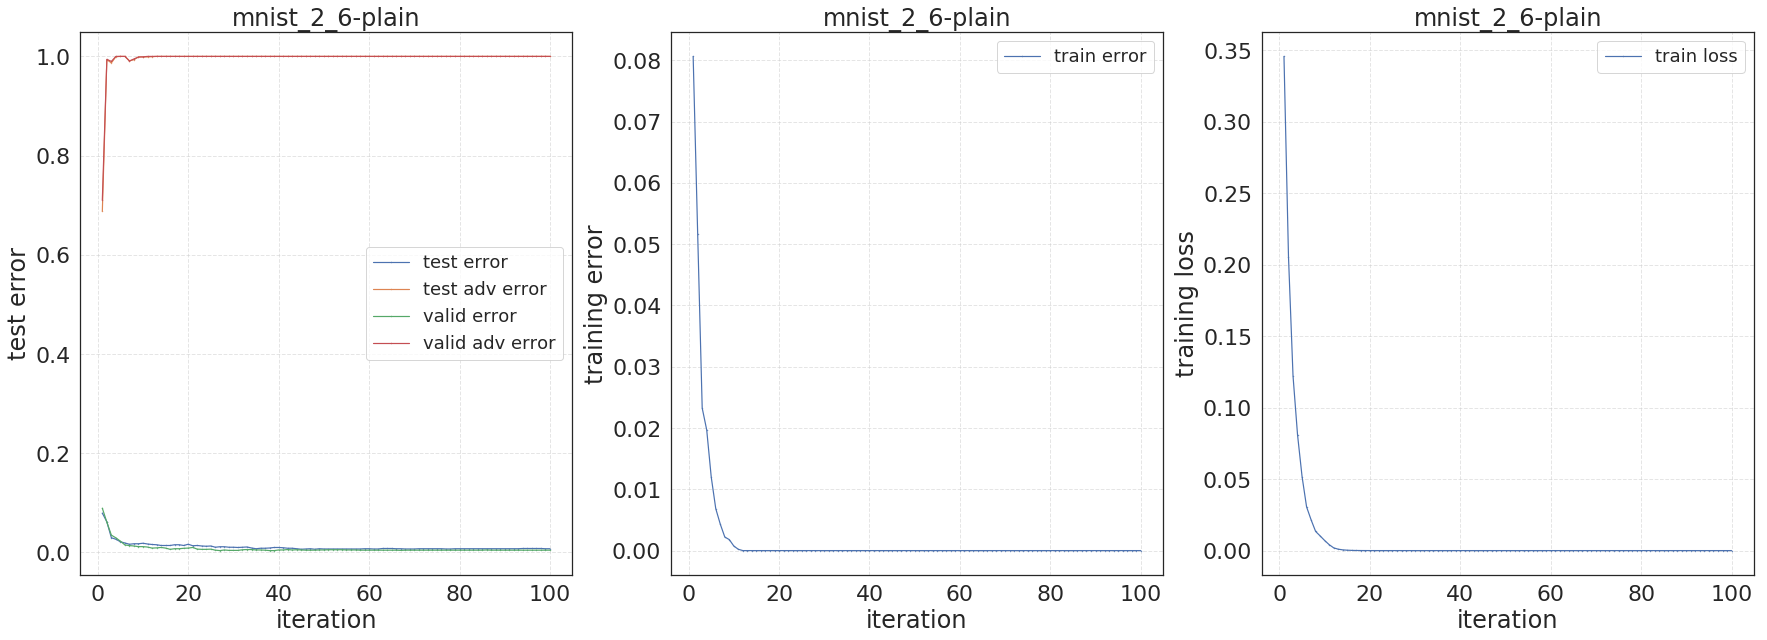

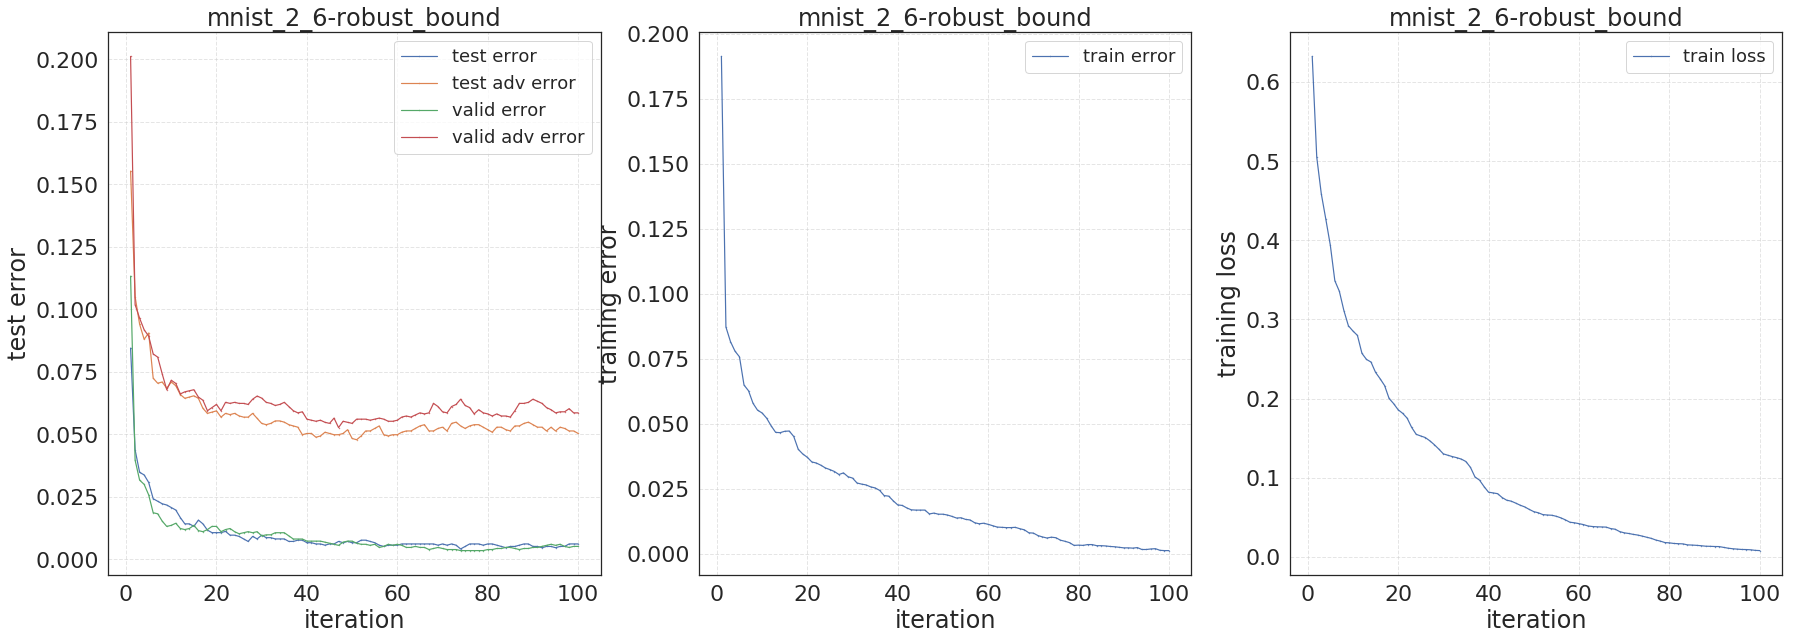

In [2]:
flag_plot = True
weak_learner = 'tree'
exp_folder = 'exps'
models = ['plain', 'robust_bound', 'robust_exact']
# datasets = ['breast_cancer', 'diabetes', 'cod_rna', 'mnist_2_6', 'fmnist_sandal_sneaker', 'gts_120_warning', 'gts_30_70']
datasets = ['mnist_2_6']

model_names = []
for dataset in datasets:
    for model in models:        
        # Reported stumps: (21 May) *15:41* for non GTS and *18:47* for GTS; MNIST is new from 25 May
        # around 11: lr=0.1, depth=6, bad LB evaluation
        # *14.1*: lr=1.0, depth=6, bad LB evaluation
        # *14.5*: lr=0.1, depth=6, proper LB evaluation (number should be the same as in the tabl)
        search_str = '{}/*dataset={} weak_learner={} model={}*.metrics'.format(exp_folder, dataset, weak_learner, model)
        model_names_curr = glob.glob(search_str)
        model_names_curr.sort(key=lambda x: os.path.getmtime(x))
        if model_names_curr != []:
            model_name_final = model_names_curr[-1]
            model_name_final = model_name_final.split('.metrics')[0].split(exp_folder+'/')[1]
            model_names.append(model_name_final)

latex_str = ''
for i, model_name in enumerate(model_names):
    print('Model name: {}'.format(model_name))
    dataset = model_name.split('dataset=')[1].split(' ')[0]
    model = model_name.split('model=')[1].split(' ')[0]
    eps = model_name.split('eps=')[1].split(' ')[0]
    
    metrics_path = model_name + '.metrics'
    metrics = np.loadtxt(exp_folder + '/' + metrics_path)
    
    # needed for plots
    iters = metrics[:, 0]
    test_errs, test_adv_errs = metrics[:, 1], metrics[:, 3]
    train_errs, train_adv_errs = metrics[:, 5], metrics[:, 6]
    train_losses = metrics[:, 7]
    valid_errs, valid_adv_errs = metrics[:, 8], metrics[:, 10]
    
    # Model selection is done
    iter_to_print = np.argmin(valid_errs) if model == 'plain' else np.argmin(valid_adv_errs)
    
    # needed to print it directly or for latex table
    last_iter, time_elapsed = int(metrics[iter_to_print, 0]), metrics[iter_to_print, -1]
    test_err, test_adv_err_lb, test_adv_err, test_adv_err_ub = metrics[iter_to_print, 1:5]
    train_err, train_adv_err, train_loss = metrics[iter_to_print, 5:8]
    valid_err, valid_adv_err_lb, valid_adv_err, valid_adv_err_ub = metrics[iter_to_print, 8:12]
    
    test_str = 'iter: {}  [test] err {:.2%} adv_err_lb {:.2%} adv_err {:.2%}  adv_err_ub {:.2%}'.format(
        last_iter, test_err, test_adv_err_lb, test_adv_err, test_adv_err_ub)
    valid_str = '[valid] err {:.2%} adv_err {:.2%}'.format(
        valid_err, valid_adv_err)
    train_str = '[train] err: {:.2%}  adv_err: {:.2%}  loss: {:.5f}'.format(
        train_err, train_adv_err, train_loss)
    print('{}  |  {}  |  {}  ({:.2f} min)'.format(test_str, valid_str, train_str, time_elapsed/60))
    
    # form the latex table
    # TODO: 100.0 -> 100 (to reduce space a bit)
    if model == 'plain':
        latex_str += '{} & {} &'.format(dataset.replace('_', ' '), eps)
    if weak_learner == 'stump':
        latex_str += '{:.1f} & {:.1f} & {:.1f}'.format(
        test_err*100, test_adv_err*100, test_adv_err_ub*100)
    else:
        latex_str += '{:.1f} & {:.1f} & {:.1f}'.format(
        test_err*100, test_adv_err_lb*100, test_adv_err_ub*100)
    if weak_learner == 'stump' and model == 'robust_exact' or weak_learner == 'tree' and model == 'robust_bound':
        latex_str += r' \\' + '\n'  # new table line
    else:
        latex_str += ' &   '  # just a margin for better latex code quality
    
    if flag_plot:
        plot_name_short = '{}-{}'.format(dataset, model)
        plot_name_long = 'dataset={}-model={}-iter={}'.format(dataset, model, last_iter)
        fig, axs = plt.subplots(1, 3, figsize=(3*plot_height, plot_height)) # sharex=True, sharey=True
    
        axs[0].plot(iters, test_errs, label='test error', linestyle='solid', linewidth=line_width, marker='o', markersize=marker_size)
        axs[0].plot(iters, test_adv_errs, label='test adv error', linestyle='solid', linewidth=line_width, marker='o', markersize=marker_size)
        axs[0].plot(iters, valid_errs, label='valid error', linestyle='solid', linewidth=line_width, marker='o', markersize=marker_size)
        axs[0].plot(iters, valid_adv_errs, label='valid adv error', linestyle='solid', linewidth=line_width, marker='o', markersize=marker_size)
        axs[0].set_xlabel('iteration')
        axs[0].set_ylabel('test error')
        # prec = 1 if np.round(test_adv_errs.max() - test_errs.min(), 1) != 0.0 else 3
        # y_min, y_max = test_errs.min().round(prec), test_adv_errs.max().round(prec)
        # axs[0].set_yticks(np.arange(y_min, y_max, (y_max - y_min) / 10))
        axs[0].grid(which='both', alpha=0.5, linestyle='--')
        axs[0].legend(loc='best', prop={'size': legend_size})
        axs[0].set_title(plot_name_short)
        
        axs[1].plot(iters, train_adv_errs, label='train error', linestyle='solid', linewidth=line_width, marker='o', markersize=marker_size)
        axs[1].set_xlabel('iteration')
        axs[1].set_ylabel('training error')
        # prec = 1 if np.round(test_adv_errs.max() - train_adv_errs.min(), 1) != 0.0 else 3
        # y_min, y_max = train_adv_errs.min().round(prec), train_adv_errs.max().round(prec)
        # axs[1].set_yticks(np.arange(y_min, y_max, (y_max - y_min) / 10))
        axs[1].grid(which='both', alpha=0.5, linestyle='--')
        axs[1].legend(loc='best', prop={'size': legend_size})
        axs[1].set_title(plot_name_short)
        
        axs[2].plot(iters, train_losses, label='train loss', linestyle='solid', linewidth=line_width, marker='o', markersize=marker_size)
        axs[2].set_title(plot_name_short)
        axs[2].set_xlabel('iteration')
        axs[2].set_ylabel('training loss')
        # prec = 1 if np.round(train_losses.max() - train_losses.min(), 1) != 0.0 else 3
        # y_min, y_max = train_losses.min().round(prec), train_losses.max().round(prec)
        # axs[2].set_yticks(np.arange(y_min, y_max, (y_max - y_min) / 10))
        axs[2].grid(which='both', alpha=0.5, linestyle='--')
        axs[2].legend(loc='best', prop={'size': legend_size})
        axs[2].set_title(plot_name_short)
    
        plt.savefig('plots/{}.pdf'.format(plot_name_long), bbox_inches='tight')
    if weak_learner == 'stump' and i % 3 == 2:
        print()
    if weak_learner == 'tree' and i % 2 == 1:
        print()


# TODO: implement boldfacing too. Probably, collect the numbers in an array.
print()
print('Latex table:')
print(latex_str)

